# Exercise 4

Exercise 4 includes five problems that you need to solve with programming, and by providing answers to questions. For each problem you need to modify the notebook by adding your own solutions. Remember to save and commit your changes locally, and push your changes to GitHub after each major change! Regular commits will help you to keep track of your changes (and revert them if needed). Pushing your work to GitHub will ensure that you don't lose any work in case your computer crashes (can happen!).

### Time allocation

**Completing this exercise takes approximately: 2-6 hours** (based on previous year statistics). However, the time it takes can vary significantly from student to student, so we recommended that you start immediately working on the exercise to avoid issues meeting with the deadline.  

### Due date

You should submit (push) your Exercise answers to your personal Github repository **by Friday 29th November at 23:59**. 
      
### Start your exercise in CSC Notebooks

Before you can start programming, you need to launch the CSC Notebook instance and clone your **personal copy of the Exercise repository** (i.e. something like `exercise-4-htenkanen`) there using Git. If you need help with this, [read the documentation on the course site](https://spatial-analytics.readthedocs.io/en/latest/lessons/L1/git-basics.html).

### Working with Jupyter Notebooks

Jupyter Notebooks are documents that can be used and run inside the JupyterLab programming environment (e.g. at [noppe.csc.fi](https://noppe.csc.fi/)) containing the computer code and rich text elements (such as text, figures, tables and links). 

**A couple of hints**:

- You can **execute a cell** by clicking a given cell that you want to run and pressing <kbd>Shift</kbd> + <kbd>Enter</kbd> (or by clicking the "Play" button on top)
- You can **change the cell-type** between `Markdown` (for writing text) and `Code` (for writing/executing code) from the dropdown menu above. 

See [**further details and help from here**](https://pythongis.org/part1/chapter-01/nb/04-using-jupyterlab.html). 

### Working with Git/Github

If you need help working with Git/Github related to the Exercise, please check the [Tutorial 0 on the course website](https://introsda.readthedocs.io/en/latest/tutorials/git-basics.html).
 
### Hints 

If there are general questions arising from this exercise, we will add hints to the course website under [Exercise 4 description](https://introsda.readthedocs.io/en/latest/exercises/exercise-4.html). 

## Introduction

In this exercise, you will practice using some of the basic DEM analysis approaches using Python's [Xarray](http://xarray.pydata.org/en/stable/) and [Xarray-spatial](https://xarray-spatial.readthedocs.io/) libraries, in order to gain knowledge of topography of an area and use different raster layers to find a suitable place for your scenario. You’ll be using elevation, slope and aspect, so think of a scenario where all of these can be utilized. In these instructions, **placing a summer cottage will be used as an example with the following preferences**:

- **the higher the better**
- **some slope is good but not too steep**
- **the ridge should be pointing southwards (who wouldn't like more sun on their patio..)**

Feel free to use your own scenario if you wish, as long as you come up with one that utilizes the same layers or use the same as in these instructions.
The goal in this exercise is to calculate **weighted overlay**. For each preference, you need to create a raster layer and combine them using weighted sum. You’ll need to:

- run different functions to get the layers (e.g. slope and aspect)
- reclassify the layers according to your preferences
- sum all layers together (weighting), and
- smooth the results to get a more general view on the suitability (optional).

When doing an overlay analysis such as this, it is important to ensure the preference layers are scaled in a similar, for example from 1 to 5 (which is the scale used in the instuctions).


## Data

In the exercise, we use elevation data (`data/22S_DEM.tif`) from eastern Finland, which is in [GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) format and provided for you in the `data` -directory. 

## Helper functions

These functions show some basic functionalities of `xarray` and `xarray-spatial` libraries. They are provided for you to make things easier and **for you to learn how things work** (by looking at how the commands in these functions have been written). In addition, read the documentation of [Xarray](http://xarray.pydata.org/en/stable/) and [Xarray-spatial](https://xarray-spatial.readthedocs.io/) libraries to learn more.

In [50]:
def plot_layer(dataset, attribute, contours=False):
    """
    Helper function to plot a simple map of given attribute in Xarray dataset (such as "elevation").
    
    Note: As you can see, plotting in xarray works in a similar manner as when plotting with Geopandas or Pandas.
    If you want to adjust more the visual appearance of your map, you create your own function or run the commands 
    presented in this example. 
    
    Parameters
    ==========
    
    dataset : xarray.core.dataset.Dataset
    
        The input Xarray Dataset that should contain the data `attribute` which you want to visualize.
        
    attribute : str
    
        The name of the data attribute (layer) that you want to visualize.
        
    contours : bool
    
        If True, adds contours to the map. 
    
    """
    import matplotlib.pyplot as plt
    
    
    # Initialize an empty figure
    fig, ax = plt.subplots(figsize=(12,12))
    
    # Plot the layer using the .plot() function
    data[attribute].plot(ax=ax)

    # Add contours if requested
    if contours:
        
        # Add contours on top to make the map easier to understand
        cs = data[attribute].plot.contour(ax=ax, colors="red")

        # Label contours
        ax.clabel(cs, cs.levels, inline=True, fontsize=8);
    
    # Return the matplotlib axis object
    return ax


def plot_hillshade(dataset, elevation_col):
    """
    A helper function which:
    1) calculates a hillshade based on elevation and stores it as "hillshade" attribute,
    2) visualizes the hillshade creating a 3D like appearance, and 
    3) colors the hillshade based on the elevation values.
    
    HINT: Take a look how the xarray-spatial library was used to calculate the hillshade. In a similar manner,
    you can calculate also slope and aspect by using the dedicated functions for them available in the 
    xarray-spatial library, read docs here: https://xarray-spatial.readthedocs.io/en/stable/user_guide/surface.html#Hillshade
    
    Parameters
    ==========
    
    dataset : xarray.core.dataset.Dataset
    
        The input Xarray Dataset that should contain the `elevation` data attribute which is used for calculating/visualizing the hillshade.
        
    elevation_col : str
    
        The name of the data attribute that contains the elevation values. 
     
    """
    
    # Xarray-spatial library
    import xrspatial as xs
    import numpy as np
    
    # Functions from datashader library to stack (merge) multiple images together 
    # and plot them with `shade` command
    from datashader.transfer_functions import shade, stack
    
    # A predefined colormap which is good for visualizing Elevation
    from datashader.colors import Elevation
    
    # Calculate hillshade and store it as attribute "hillshade"
    data["hillshade"] = xs.hillshade(data[elevation_col])

    # Stack multiple layers on top of each other and blend them nicely
    # Note: np.flip is used to reorient the axis 0, so that the orientation of the image corresponds to the reality 
    # See: https://github.com/holoviz/datashader/issues/1054#issuecomment-1153769263
    return stack(
    shade(np.flip(data["hillshade"], 0), cmap=['gray', 'white'], alpha=255, how='linear'),
    shade(np.flip(data["elevation"], 0),     cmap=Elevation,         alpha=128, how='linear'),
    )
    
    

## Problem 1 - Data exploration (3 points) 

### About the libraries used

In this exercise, we are using xarray and xarray-spatial libraries a lot. They are libraries that make working with multidimentional data easy (such as raster data). **They work in a quite similar manner as pandas/geopandas**, but they represent/store data as **matrises** (multidimentional arrays) instead of columns (Series) in a GeoDataFrame. But the intuitition and the "feel" of using xarray Datasets is quite similar as when working with GeoDataFrames. Hence, using the Xarray Datasets should be quite straightforward if you have some experience in working with pandas/geopandas.

### Task 1.1 - Read the data, explore the `xarray.Dataset` object 

- Read the data into `data` variable using the `.open_rasterio()` -function ([read docs](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-open-rasterio)) of the rioxarray library as shown below. The command below (provided for you) actually does a few things:
  - It first reads the data from the given filepath (`fp`)
  - It then removes one unnecessary dimension of the data (called `band`) using the [`squeeze()` -function](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.squeeze.html). The `band` is not needed here: it would be useful if the input data would e.g. be a satellite color image with three bands, one for each color channel (Red, Green, Blue), but here we only have one layer that represents the elevation values.
  - Finally the command converts the [DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) into a xarray [Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) which is a bit similar object as GeoDataFrame of the geopandas library.
  
- Explore the `data` using programming and find out (add your answer to "Answers" section below):
  - What is the **maximum** `"elevation"` value in the data?
  - What is the **minimum** elevation value in the data?
  - What is the **mean** elevation in the data?
  - Hint: You can find these in a similar manner as in pandas/geopandas. **Notice** that by default, the xarray always returns values as an array (even if the result is a scalar value, such as number 1)

In [40]:
import xarray as xr
import xrspatial as xs
import rioxarray 


# Read the DEM and convert to Xarray DataSet 
# which is a similar thing as pandas DataFrame but works with raster/matrices
fp = "data/22S_DEM.tif"

# The elevation values will be read into a variable "elevation"
data = rioxarray.open_rasterio(fp).squeeze("band", drop=True).to_dataset(name="elevation")

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
max_elevation = data["elevation"].max().item()
min_elevation = data["elevation"].min().item()
mean_elevation = data["elevation"].mean().item()

print(f"Maximum elevation: {max_elevation}")
print(f"Minimum elevation: {min_elevation}")
print(f"Mean elevation: {mean_elevation}")


Maximum elevation: 2294
Minimum elevation: 1342
Mean elevation: 1663.44648125


### Questions

*Correct answers gives you 1 point allocated to problem 1.1*.

- **Question 1.1**: What is the **maximum** `"elevation"` value in the data?
- **Question 1.2**: What is the **minimum** elevation value in the data?
- **Question 1.3**: What is the **mean** elevation in the data?

### Answers

Answer to the questions by adding text after the `Answer` bullet points below:

(hint: double-click this cell to activate editing)

- **Answer for Q1.1**:2294
- **Answer for Q1.2**:1342
- **Answer for Q1.3**:1663

### Task 1.2 - Visualize the data

1. **Visualize the `elevation`** by using the `plot_layer()` function provided for you in the [Helper functions](#Helper-functions) above.
2. **Visualize the same data by applying a `hillshade`** into the data which creates an illusion of 3D map. You can do this by taking advantage of the `plot_hillshade()` -function provided for you in the [Helper functions](#Helper-functions). 

As a result of these steps, you should get maps like below: 

![Elevation](img/elevation.png)

*Example map showing the elevation in the study area*.

![Hillshade](img/hillshade.png)

*Example map visualized using hillshade that creates an illusion of 3D*.

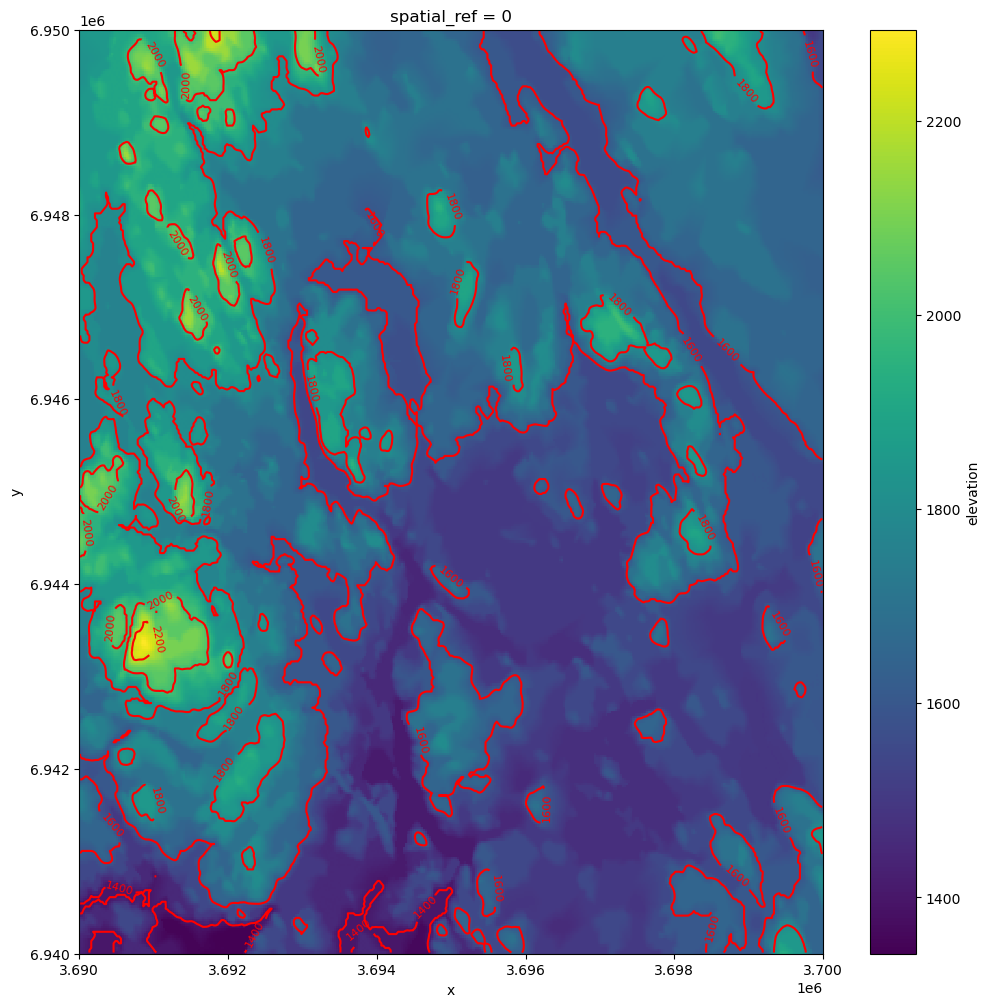

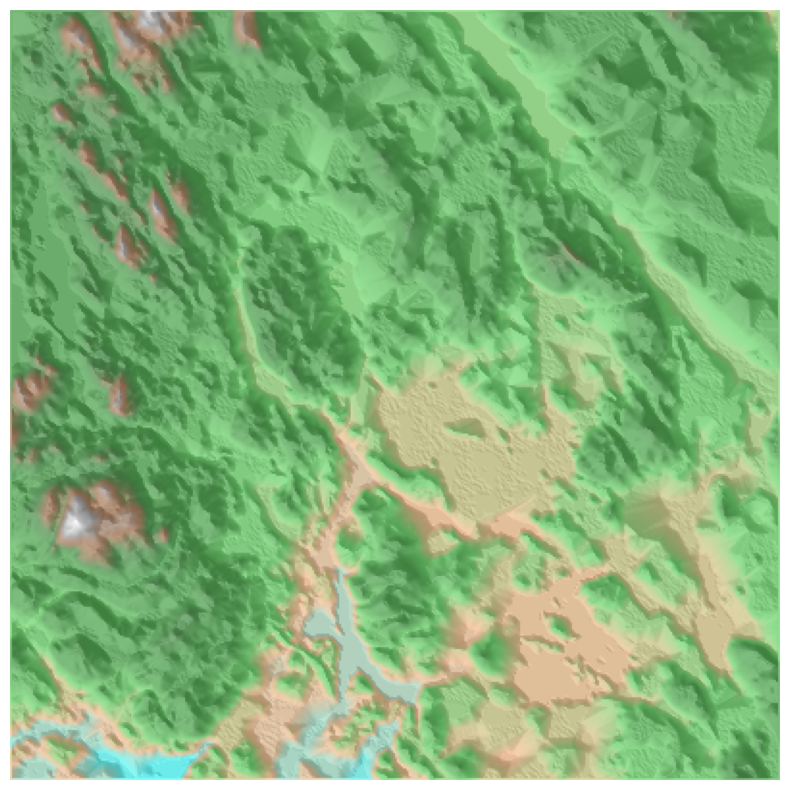

In [41]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
import matplotlib.pyplot as plt

elevationimg = plot_layer(data, "elevation", contours=True)

hillshade = plot_hillshade(data, "elevation")

from matplotlib.pyplot import imshow, axis, show, figure

figure(figsize=(10, 10))
imshow(hillshade.to_pil())
axis("off")
show()



### Questions

*Answering these questions gives you 0.5 points allocated to problem 1.2*.

- **Question 1.4**: Which of the maps do you think is more informative? Describe/justify your thoughts.
- **Question 1.5**: Which of the maps do you think is more visually pleasing? Describe/justify your thoughts.

### Answers

Answer to the questions by adding text after the `Answer` bullet points below:

(hint: double-click this cell to activate editing)

- **Answer for Q1.4**:The elevation map is more informative as it has exact values for the elevations listed and the differences of elevations are easily distributed.
- **Answer for Q1.5**:The hillshade map is more visually pleasing as it looks more realistic and the colors blend together. Also the 3d-visuals are pleasing.

## Problem 2 - Calculate Slope and Aspect + visualize (6 points)

### Task 2.1 - Slope

- **Calculate the slope** using the [`.slope()` -function](https://xarray-spatial.readthedocs.io/en/stable/user_guide/surface.html#Slope) available in xarray-spatial library and store the result in attribute `"slope"`
  - Hint: Take example from the `plot_hillshade()` function in the [Helper functions](#Helper-functions), which shows how the `hillshade` variable is calculated.

- **Plot the result** (i.e. `slope`) using the `.plot()` -function. Use colormap `"Greens"`. As a result you should get something like below (the title `Slope (degrees)` is optional):

![Slope](img/slope.png)

*Example map showing the slope.*

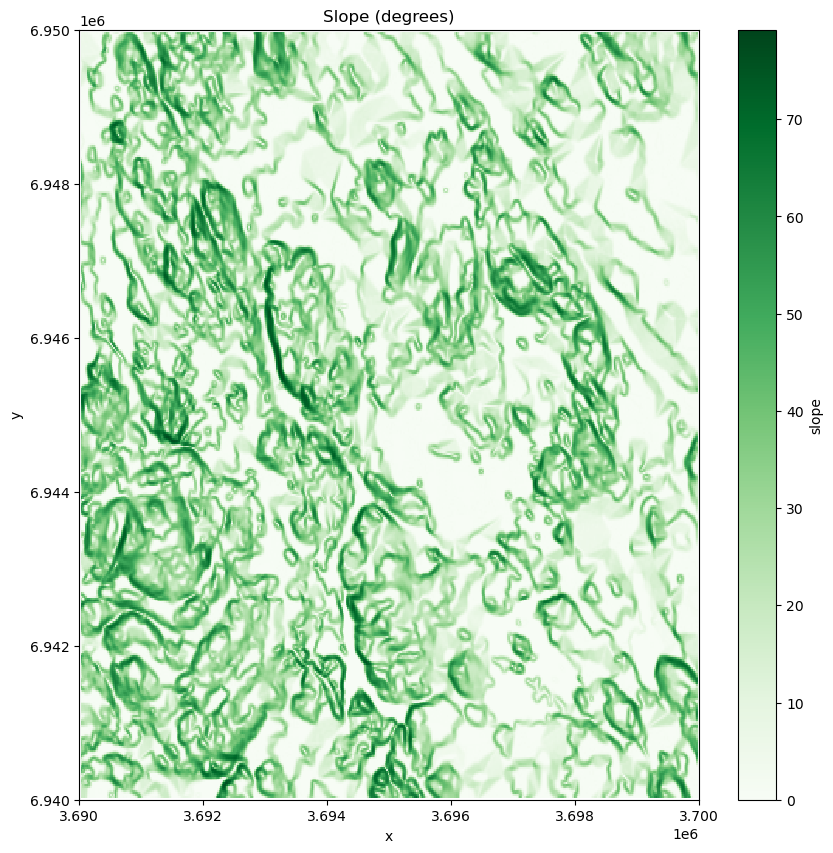

In [42]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data["slope"] = xs.slope(data["elevation"])

fig, ax = plt.subplots(figsize=(10, 10))
data["slope"].plot(ax=ax, cmap="Greens") 
ax.set_title("Slope (degrees)")
plt.show()


### Questions

*Answering these questions gives you 0.5 points allocated to problem 2.1*.

- **Question 2.1**: Based on the slope map, are there any steep slopes visible in the terrain? Justify your answer. 


### Answers

Answer to the questions by adding text after the `Answer` bullet points below:

(hint: double-click this cell to activate editing)

- **Answer for Q2.1**:There are lots of steep slopes visible in the terrain. The dark green (high slope) next to small slope values indicate steep slopes.

### Task 2.2 - Aspect

- **Calculate the aspect** using the [`.aspect()` -function](https://xarray-spatial.readthedocs.io/en/stable/user_guide/surface.html#Slope) available in xarray-spatial library and store the result in attribute `"aspect"`
  - Hint: Take example from the `plot_hillshade()` function in the [Helper functions](#Helper-functions), which shows how the `hillshade` variable is calculated.
- **Filter out -1 values** which represent cells that are flat (hence they do not have aspect):
  - Update the `"aspect"` attribute using `.where()` function that allows [masking the data](https://xarray.pydata.org/en/v0.9.5/indexing.html#masking-with-where) based on user-defined criteria. 
  - Hence, you should do something like: `data["aspect"] = data["aspect"].where(ADD-YOUR-CRITERIA-HERE)`

- **Question 2.2**: What is the average aspect in the data? Explore the data and find out the answer using programming. (Add your answer to "Answers" section below).

- **Plot the result** (i.e. `slope`) using the `.plot()` -function. Use colormap `"jet"`. As a result you should get something like below (the title `Aspect ...` is optional):

![Aspect](img/aspect.png)

*Example map showing the aspect.*


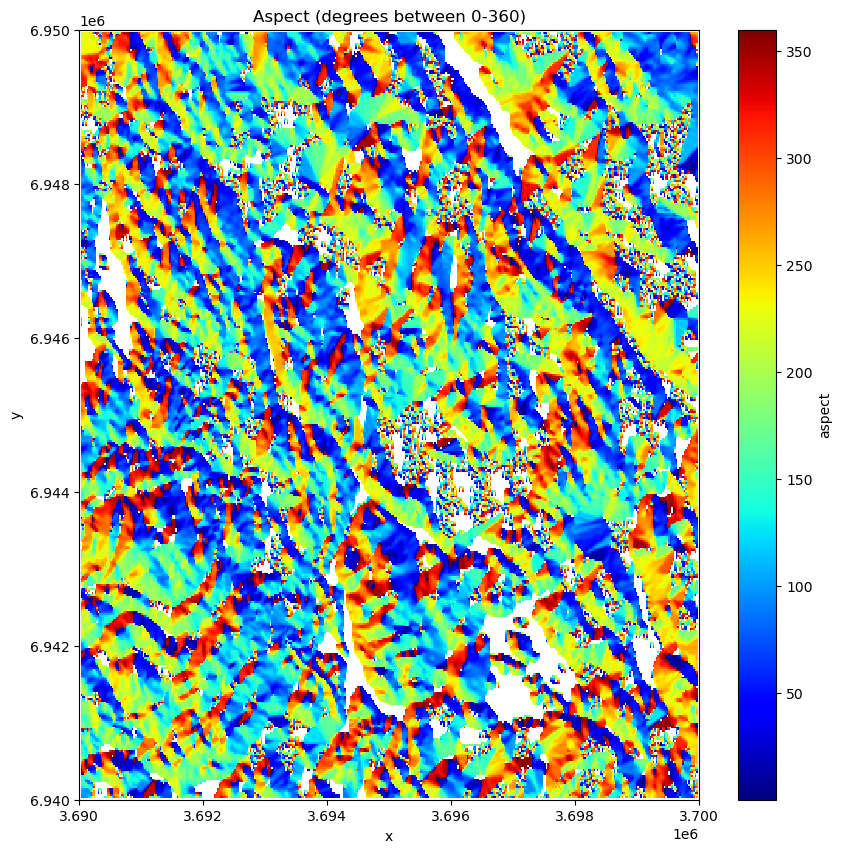

168.52


In [43]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
import numpy as np
from xrspatial import aspect
import matplotlib.pyplot as plt

data["aspect"] = aspect(data["elevation"])

data["aspect"] = data["aspect"].where(data["aspect"] > 0)

fig, ax = plt.subplots(figsize=(10, 10))
data["aspect"].plot(ax=ax, cmap="jet")
ax.set_title("Aspect (degrees between 0-360)")
plt.show()

average_aspect = data["aspect"].mean().item()
print(f"{average_aspect:.2f}")



### Questions

*Answering these questions gives you 0.5 points allocated to problem 2.2*.

- **Question 2.2**: What is the average aspect in the data?

### Answers

Answer to the questions by adding text after the `Answer` bullet points below:

(hint: double-click this cell to activate editing)

- **Answer for Q2.2**:153.01

## Problem 3 - Reclassify and weight the values (6 points)

### Reclassification

In order to combine data from several layers for analysis, you should scale the values in the different layers to a common scale. We do this by using reclassification. Hence, let’s reclassify our three layers (DEM, aspect and slope) one at a time. You should use scale from **1 (worst) to 5 (best)** in each layer.

### Step 3.1 - Classify elevation based on Natural Breaks

- Classify the **elevation** values by using a classifier called `.natural_breaks()` ([read docs](https://xarray-spatial.readthedocs.io/en/stable/user_guide/classification.html#Natural-Breaks-(Jenks)-Reclassify)) that is available in the `xarray spatial` -library: 
  - The **number of classes should be 5**, which can be specified with parameter `k`. 
  - When classifying, let's use a 20 % sample of the cells to define the class breaks. This sampling is used, because it makes the classification process faster. The sample size is provided for you in the variable `n` below. **Pass the sample size by using parameter `num_sample`** to the `.natural_breaks()` function
  - **Store the values in attribute `"elevation_points"`.**
- By default the `.natural_breaks()` classifier classifies the values into number between 0 to 4. Number 0 is problematic for us, because 0 does not have any weight in the overlay analysis. Hence, **modify the `"elevation_points"` attribute by adding a number 1 to the result** (i.e. 0 becomes 1, 1 becomes 2, etc.).
- **Plot the result** (i.e. `elevation_points`) using the `.plot()` -function. As a result you should get something like below (*notice the additional scalebar on the right side showing the elevation in meters is not required. It is just here provided for you as a reference*):

![Elevation points](img/elevation_points.png)

*Example map showing the elevation points (with additional scalebar which is not required from you).*


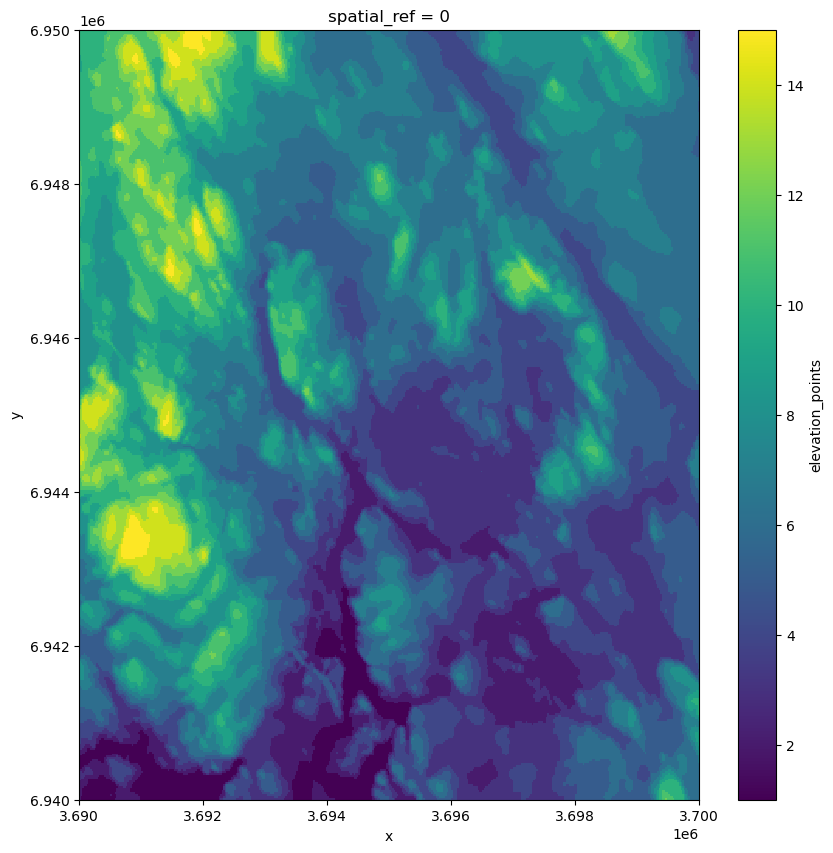

In [44]:
# Take 20 % sample to reduce the time it takes to classify
percentage = 0.2

# The sample size
n = int(round(int(data["elevation"].count()) * percentage, 0))

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
from xrspatial.classify import natural_breaks
from xrspatial import hillshade

data["elevation_points"] = natural_breaks_agg = natural_breaks(data["elevation"], n, k=15)
data["elevation_points"] = data["elevation_points"] + 1

fig, ax = plt.subplots(figsize=(10, 10))
data["elevation_points"].plot(ax=ax, cmap="viridis")
plt.show()



### Step 3.2 - Classify the slope using Natural Breaks + modify the values with own criteria

In this step, we first classify the slope values into five classes using natural breaks classifier and store them in `slope_nb` attribute. Then we will shuffle those `slope_nb` values based on criteria which will give highest points to the class number 2 (details below).

1. **Classify the slope** values by using a classifier called `.natural_breaks()` ([read docs](https://xarray-spatial.readthedocs.io/en/stable/user_guide/classification.html#Natural-Breaks-(Jenks)-Reclassify)) that is available in the `xarray spatial` -library: 
    - The **number of classes should be 5**, which can be specified with parameter `k`. 
    - When classifying, use again 20 % sample of the cells for defining the class breaks (as in step 3.1). You should again use the variable `n` as previously. **Pass the sample size by using parameter `num_sample`** to the `.natural_breaks()` function
    - **Store the values in attribute `"slope_nb"`.**
2. **Reclassify the `slope_nb` values** from the previous step by using a classifier called `.reclassify()` ([read docs](https://xarray-spatial.readthedocs.io/en/stable/reference/_autosummary/xrspatial.classify.reclassify.html)). 
   - You can use the `bins` and `values` variables with the function that are provided for you below. The comment in the code cell below explains how the points are assigned to different classes.
   - **Store the values in attribute `"slope_points"`.**

3. **Plot the result** (i.e. `slope_points`) using the `.plot()` -function. You can use the colormap `"Greens"`. As a result you should get something like below:

![Slope points](img/slope_points.png)

*Example map showing the slope points.*


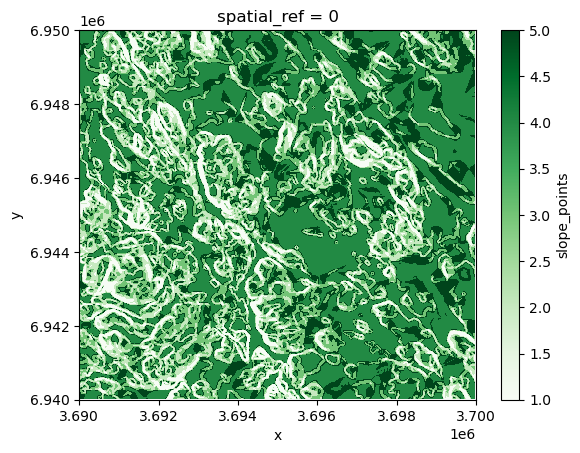

In [45]:
# Reclassify the slope values into 5 classes using Natural Breaks (clustering method) 
# and add 1 to get the class values range between 1-5 
data["slope_nb"] = xs.classify.natural_breaks(data["slope"], k=5)
data["slope_nb"] = data["slope_nb"] + 1

# Assign points for the Natural break values
# Class number 2 gets highest points (5)
# Class number 1 gets 4 points
# Class number 3 gets 3 points
# Class number 4 gets 2 points
# Class number 5 gets 1 point (this has very steep slope so we do not want to give much weight to it)

# You can use these 
bins = [1,2,3,4,5]
new_values = [4,5,3,2,1]

# Reclassify the slope_nb values
data["slope_points"] = xs.reclassify(data["slope_nb"], bins=bins, new_values=new_values)


# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data["slope_points"].plot(cmap="Greens")

### Step 3.3 - Classify the aspect to custom classes using `reclassify`

- **Classify the aspect** values by using a classifier called `.reclassify()` ([read docs](https://xarray-spatial.readthedocs.io/en/stable/reference/_autosummary/xrspatial.classify.reclassify.html)). 
   - You can use the `bins` and `values` variables with the function that are provided for you below. The comment in the code cell below explains how the points are assigned to different classes.
   - **Store the values in attribute `"aspect_points"`.**
- **Plot the result** (i.e. `aspect_points`) using the `.plot()` -function. You can use the colormap `"RdYlBu_r"`. As a result you should get something like below:

![Aspect points](img/aspect_points.png)

*Example map showing the aspect points.*

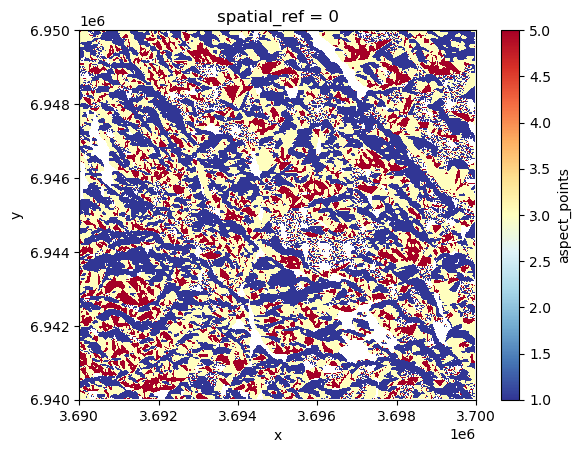

In [46]:
# Reclassify aspect into 3 classes where:
# - aspects pointing South (between 150-210 degrees) get biggest value 5
# - aspects pointing East or West (between 90-150 and 210-270) get value 3
# - aspects point North (below 90 degrees and above 270 degrees) get value 1

# You can use these which define the custom classifier as described above
bins = [90, 150, 210, 270, 360]
new_values = [1, 3, 5, 3, 1]

# Classify
data["aspect_points"] = xs.reclassify(data["aspect"], bins=bins, new_values=new_values)


# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data["aspect_points"].plot(cmap="RdYlBu_r")

## Problem 3 - Local map algebra (2 points)

As a simple example of local function you now should add the reclassified layers together. One way could be just to add the values so that every cell had a value from 3 to 15, but this is rather simple and you can skip it. Instead, you should assign weights to the layers so that for example good aspect is more important than good elevation. One way is to have a weight factor for each layer.

We apply a simple expression and weight our values with following formula:

- `0.2*DEM + 0.6*Aspect + 0.2*Slope`

Hence, we give most weight (60 %) to the aspect and equal amount of weight for the elevation and slope (20 % each). 

- **Calculate a suitability index** based on the formula provided above by utilizing the `elevation_points`, `slope_points` and `aspect_points`
    - **Store the result in `"suitability_index"` attribute**
- **Plot the result** (i.e. `suitability_index`) using the `.plot()` -function. You can use the colormap `"RdYlBu_r"`. As a result you should get something like below:

![Suitability index](img/suitability_index.png)

*Example map showing the suitability index. The higher the value, the better suited it is for building/buying a summer cottage based on our criteria.*

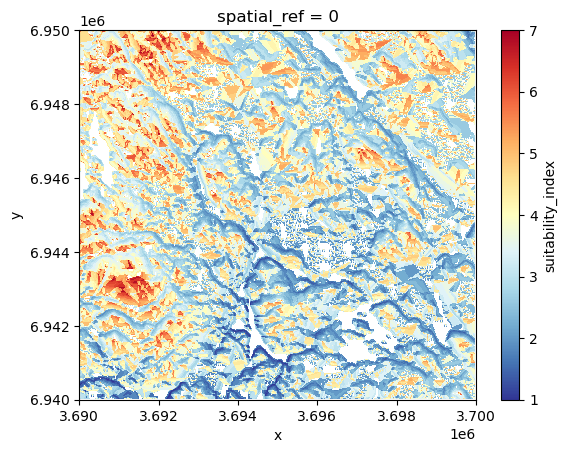

In [51]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE

data["suitability_index"] = 0.2*data["elevation_points"] + 0.6*data["aspect_points"] + 0.2*data["slope_points"]

data["suitability_index"].plot(cmap="RdYlBu_r")

## Problem 4 - Smooth the surface with focal map algebra (2 points)

In contrary to local Map Algebra which operates with single location and several layers at a time (i.e. what we did in Problem 3), focal Map Algebra concentrates on cell neighborhoods on one layer. Next, we will soften the results from the previous analysis by a focal function to get a more general view on where the suitable places are located in. We will define a circular neighborhood/kernel and smooth the result using mean. Finally, we can compare the results with the original results from Problem 3.

- Use the `kernel` (circular) provided for you below (here with window size 15x15) and apply it to `.focal_stats()` function ([read docs](https://xarray-spatial.readthedocs.io/en/stable/reference/_autosummary/xrspatial.focal.focal_stats.html)) that is available in the `xarray spatial` -library:
  - Use the `"suitability_index"` as the input data, the predefined kernel, and use `"mean"` as the statistics function in the `stats_funcs` parameter. Notice that the value provided for `stats_funcs` should be a list (including the text "mean") --> Check the docs from the link above.
  - **Store the result in `"smoothed_suitability_index"` attribute**
  
- **Plot the result** (i.e. `smoothed_suitability_index`) using the `.plot()` -function. You can use the colormap `"RdYlBu_r"`. As a result you should get something like in below.
  - Test changing the kernel size (with bigger/smaller values) 
  - **Question 4.1:** How does changing the kernel size influence your results? (Add your answer to "Answers" section below)

![Smoothed suitability index](img/smoothed_suitability_index.png)

*Example map showing the smoothed suitability index. The higher the value, the better suited it is for building/buying a summer cottage based on our criteria.*

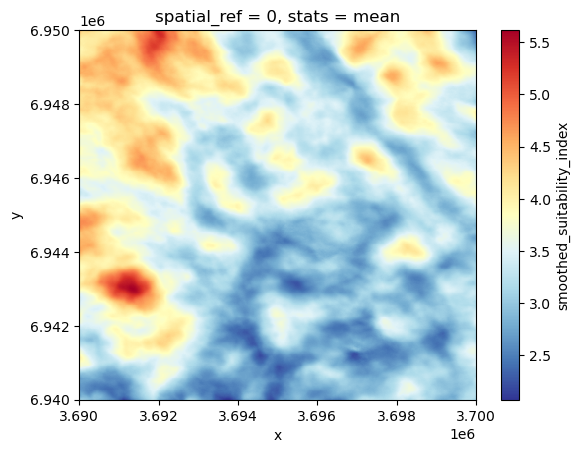

In [60]:
from xrspatial.convolution import circle_kernel
from xrspatial import focal

# Kernel size
k = 15

# Generate a kernel (basically produces a boolean matrix full with numbers 1 and 0)
kernel = circle_kernel(1, 1, k)

# Smoothen the surface
data["smoothed_suitability_index"] = focal_stats(data["suitability_index"], kernel, stats_funcs=['mean'])


# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data["smoothed_suitability_index"].plot(cmap="RdYlBu_r")

### Questions

*Answering these questions gives you 0.5 points allocated to problem 4.1*.

- **Question 4.1:** How does changing the kernel size influence your results? Justify your answer. 

### Answers

Answer to the questions by adding text after the `Answer` bullet points below:

(hint: double-click this cell to activate editing)

- **Answer for Q4.1**: 

## Problem 5 - How long did it take? Optional feedback (1 point)

To help developing the exercises, and understanding the time that it took for you to finish the Exercise, please provide an estimate of how many hours you spent for doing this exercise?

 - I spent approximately this many hours: **X hours**
 
In addition, if you would like to give any feedback about the exercise (optional), please provide it below:

 - My feedback: